In [1]:
import os, sys

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
os.environ["CUDA_VISIBLE_DEVICES"] = "7"
CORE_DIR = os.path.join(os.path.dirname(os.path.abspath(os.getcwd())), "core")
CORE_DIR_2 = os.path.join(os.path.dirname(os.path.abspath(os.getcwd())), "core/")
sys.path.append(os.path.dirname(CORE_DIR))
sys.path.append(os.path.dirname(CORE_DIR_2))

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda.amp import GradScaler
from torch.cuda.amp import autocast

import numpy as np
import argparse
from time import time
from loguru import logger
import matplotlib.pyplot as plt
import tifffile

from model import get_model
from utils.utils import load_json
from utils.data_utils import get_data, normalize_imgs, denormalize_imgs
from utils.torch_utils import setup_DDP, load_ckpt

In [2]:
@torch.inference_mode()
def run_model(imgs, model, metadata, TTA):
    imgs = torch.split(imgs, 1, dim=1)
    gap = (len(imgs) - 1) // 2
    recs = []
    for t in range(1, gap + 1):
        img0, imgT, img1 = (
            imgs[gap - t].contiguous(),
            imgs[gap].contiguous(),
            imgs[gap + t].contiguous(),
        )
        with torch.inference_mode():
            rec = model(img0, imgT, img1, TTA=True, mode="inference")
        recs.append(rec)
    recs = torch.cat(recs, dim=1).mean(dim=1, keepdim=True)

    recs = rec.squeeze().cpu().detach().numpy()
    return recs


def auto_contrast(image, sigma=2):
    mean = np.mean(image)
    std = np.std(image)

    lower_value = mean - sigma * std
    upper_value = mean + sigma * std

    image = (image - lower_value) / (upper_value - lower_value)

    return image


def fft(x):
    return np.fft.fftshift(np.fft.fftn(np.fft.fftshift(x)))

In [57]:
config = "../configs/nova/rotacell_grid1_TS09_ctf_3xBin_train.json"
cfg = load_json(config)

# seed = 1234
# max_frame_gap = 15
# coords = [400,850,800]
# patch_shape = [128,256,256]
# TTA = False
# batch_size = 32

seed = 1234
max_frame_gap = 5
coords = [432, 650, 900]
patch_shape = [128, 256, 256]
TTA = False
batch_size = 32

In [58]:
world_size, rank, device = setup_DDP(seed)
is_ddp = world_size > 1

data, metadata = get_data(cfg.data_path[0])

crop = []
for i in range(patch_shape[0]):
    z = coords[0] + i
    roi = np.asarray(
        data[
            z - max_frame_gap : z + max_frame_gap + 1,
            coords[1] : coords[1] + patch_shape[1],
            coords[2] : coords[2] + patch_shape[2],
        ]
    )
    crop.append(roi)
crop = torch.from_numpy(np.asarray(crop))
test_dataset = torch.split(crop, batch_size, dim=0)
print(len(test_dataset))

load_ckpt_path = os.path.join(cfg.train_dir, "last.pt")
model = get_model(cfg, device, is_ddp, compile=False)
model = load_ckpt(load_ckpt_path, model, is_ddp=is_ddp, compile=False)[0]
model.eval();

4


In [55]:
crop.shape

torch.Size([128, 31, 256, 256])

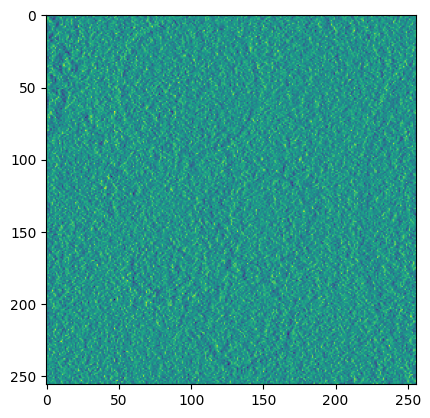

In [56]:
# plt.figure(figsize=(16,16))
plt.imshow(crop[0, 15].cpu().detach().numpy())

(667, 1920, 1364)


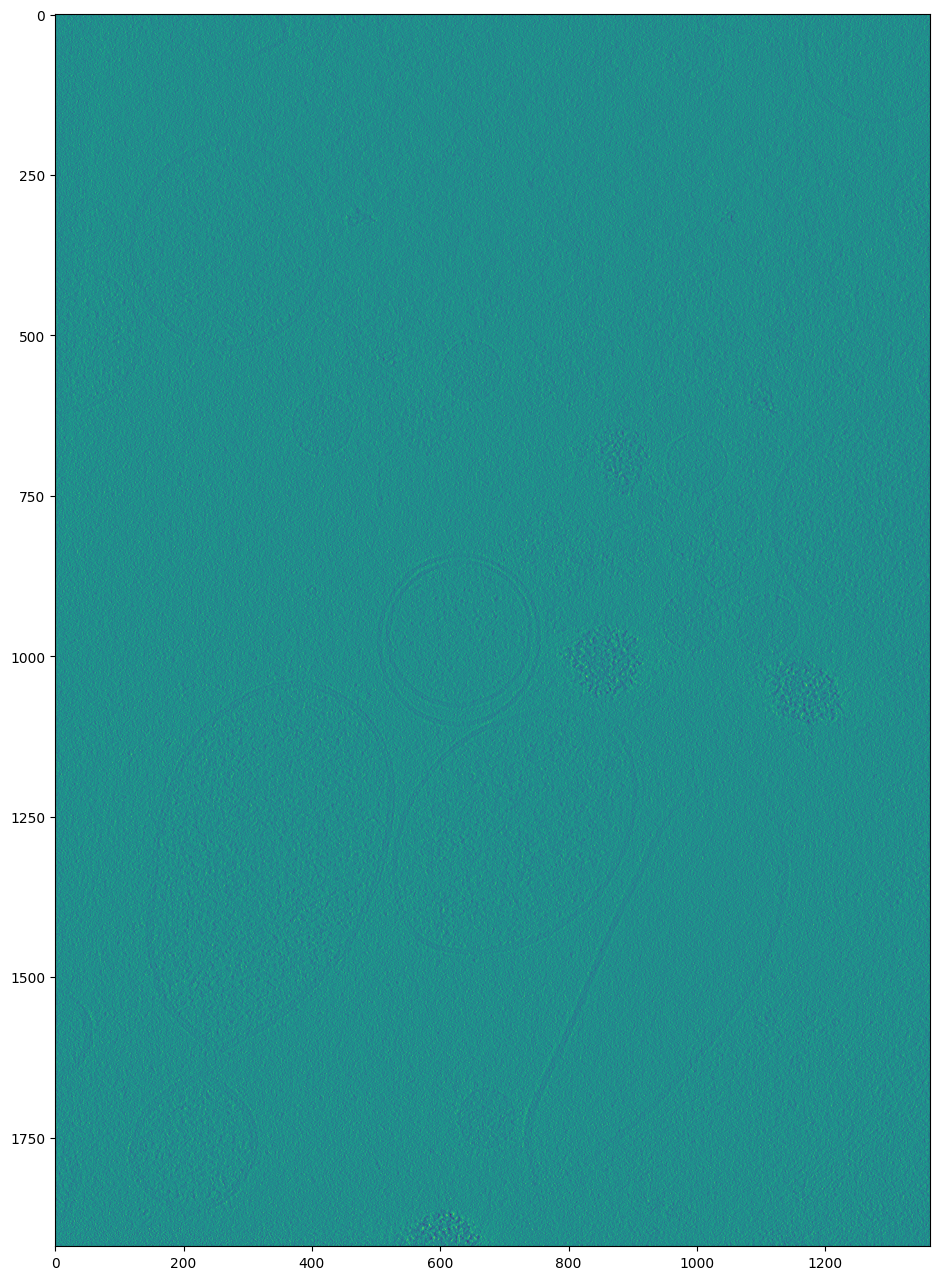

In [40]:
print(data.shape)
plt.figure(figsize=(16, 16))
plt.imshow(data[433])

In [66]:
start = time()

stack = []
for i, imgs in enumerate(test_dataset):
    imgs = imgs.to(device)
    imgs = normalize_imgs(imgs, params=metadata)

    recs = []
    for gap in range(1, max_frame_gap + 1):
        print(gap)
        middle = imgs.shape[1] // 2
        chosen = imgs[:, middle - gap : middle + gap + 1]
        rec = run_model(chosen, model, metadata, TTA=TTA)
        recs.append(rec)
    recs = np.asarray(recs)
    stack.append(recs)
    print(i, time() - start)

stack = np.concatenate(stack, axis=1)
print(stack.shape)

1
2
3
4
5
0 28.99851679801941
1
2
3
4
5
1 57.96075391769409
1
2
3
4
5
2 86.92649722099304
1
2
3
4
5
3 115.896151304245
(5, 128, 256, 256)


In [67]:
xy_crop = stack[:, stack.shape[1] // 2]
for i in range(stack.shape[0]):
    xy_crop[i] = auto_contrast(xy_crop[i], sigma=2)
# tifffile.imwrite(os.path.join(cfg.train_dir, "gaps_xy.tif"), xy_crop)

In [68]:
yz_crop = stack[:, :, stack.shape[2] // 2]
for i in range(stack.shape[0]):
    yz_crop[i] = auto_contrast(yz_crop[i], sigma=2)
# tifffile.imwrite(os.path.join(cfg.train_dir, "gaps_yz.tif"), yz_crop)

In [69]:
xz_crop = stack[:, :, :, stack.shape[3] // 2]
for i in range(stack.shape[0]):
    xz_crop[i] = auto_contrast(xz_crop[i], sigma=2)
# tifffile.imwrite(os.path.join(cfg.train_dir, "gaps_xz.tif"), xz_crop)

In [70]:
fourier = []
for i in range(stack.shape[0]):
    f = np.abs(fft(stack[i])).mean(axis=1)
    fourier.append(f)
fourier = np.asarray(fourier).astype("float")
fourier = fourier / fourier.sum(axis=(1, 2))[:, None, None]
# tifffile.imwrite(os.path.join(cfg.train_dir, "gaps_fourier.tif"), fourier)

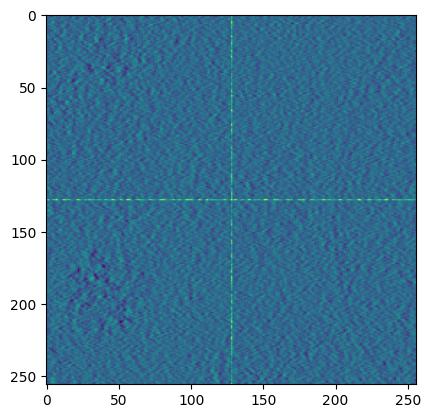

In [71]:
plt.imshow(xy_crop[0])